<a href="https://colab.research.google.com/github/HeydarAbdurahmanov/Currency_Exchange_Rate_Forecasting/blob/main/Currency_Exchange_Rate_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

df = pd.read_csv("/content/USD-TRY.csv")

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-01-02,1.3500,1.3505,1.3425,1.3495,1.3495,0.0
1,2006-01-03,1.3495,1.3495,1.3350,1.3420,1.3420,0.0
2,2006-01-04,1.3420,1.3420,1.3275,1.3328,1.3328,0.0
3,2006-01-05,1.3328,1.3374,1.3275,1.3325,1.3325,0.0
4,2006-01-06,1.3325,1.3362,1.3075,1.3280,1.3280,0.0


In [3]:
df.isnull().sum()

Date          0
Open         13
High         13
Low          13
Close        13
Adj Close    13
Volume       13
dtype: int64

In [4]:
df = df.dropna()

In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4563.000000,4563.000000,4563.000000,4563.000000,4563.000000,4563.0
mean,4.452798,4.482284,4.430058,4.453147,4.453147,0.0
std,4.782662,4.810586,4.763206,4.782782,4.782782,0.0
min,1.142300,1.153700,1.139500,1.142300,1.142300,0.0
25%,1.551650,1.564400,1.539900,1.551550,1.551550,0.0
50%,2.239200,2.249820,2.231600,2.238670,2.238670,0.0
75%,5.661080,5.698450,5.627360,5.662795,5.662795,0.0
max,26.199600,26.232100,26.095301,26.199600,26.199600,0.0


A line chart showing the trend of conversion rates over the years:

In [6]:
figure = px.line(df, x="Date",
                 y="Close",
                 title='USD - TRY Conversion Rate over the years')
figure.show()

Now let’s add year and month columns in the data before moving forward:

In [7]:
df["Date"] = pd.to_datetime(df["Date"], format = '%Y-%m-%d')
df['Year'] = df['Date'].dt.year
df["Month"] = df["Date"].dt.month
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month
0,2006-01-02,1.3500,1.3505,1.3425,1.3495,1.3495,0.0,2006,1
1,2006-01-03,1.3495,1.3495,1.3350,1.3420,1.3420,0.0,2006,1
2,2006-01-04,1.3420,1.3420,1.3275,1.3328,1.3328,0.0,2006,1
3,2006-01-05,1.3328,1.3374,1.3275,1.3325,1.3325,0.0,2006,1
4,2006-01-06,1.3325,1.3362,1.3075,1.3280,1.3280,0.0,2006,1


Now let’s have a look at the aggregated yearly growth of the conversion rates between USD and TRY:

In [8]:
import plotly.graph_objs as go
import plotly.io as pio

# Calculate yearly growth
growth = df.groupby('Year').agg({'Close': lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0]*100})

fig = go.Figure()
fig.add_trace(go.Bar(x=growth.index,
                     y=growth['Close'],
                     name='Yearly Growth'))

fig.update_layout(title="Yearly Growth of USD - TRY Conversion Rate",
                  xaxis_title="Year",
                  yaxis_title="Growth (%)",
                  width=1200,
                  height=600)

pio.show(fig)

Now let’s have a look at the aggregated monthly growth of the conversion rates between USD and TRY:

In [9]:
# Calculate monthly growth
df['Growth'] = df.groupby(['Year', 'Month'])['Close'].transform(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100)

# Group data by Month and calculate average growth
grouped_data = df.groupby('Month').mean().reset_index()

fig = go.Figure()

fig.add_trace(go.Bar(
    x=grouped_data['Month'],
    y=grouped_data['Growth'],
    marker_color=grouped_data['Growth'],
    hovertemplate='Month: %{x}<br>Average Growth: %{y:.2f}%<extra></extra>'
))

fig.update_layout(
    title="Aggregated Monthly Growth of USD - TRY Conversion Rate",
    xaxis_title="Month",
    yaxis_title="Average Growth (%)",
    width=1200,
    height=600
)

pio.show(fig)

<ipython-input-9-1bbe6aa01bff>:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Forecasting Exchange Rates Using Time Series Forecasting

We will use time series forecasting to forecast exchange rates. To choose the most appropriate time series forecasting model, we need to perform seasonal decomposition, which will help us identify any recurring patterns, long-term trends, and random fluctuations present in the USD – TRY exchange rate data:

<Figure size 640x480 with 0 Axes>

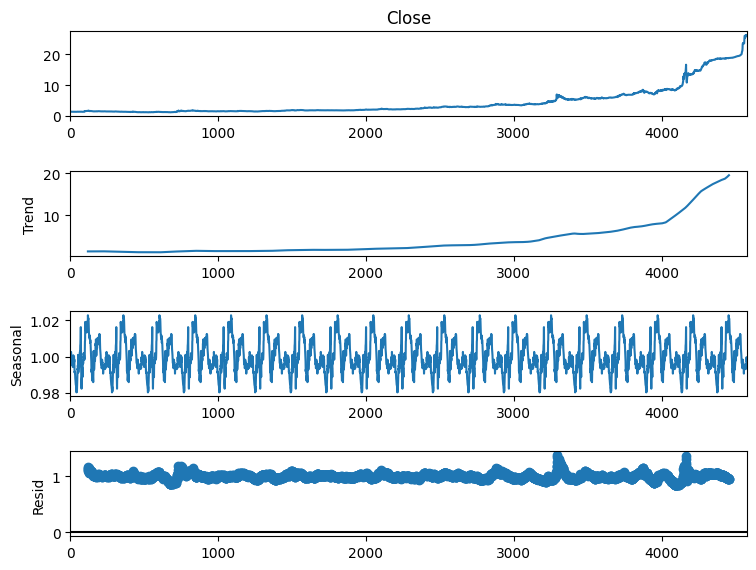

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df["Close"], model='multiplicative', period=240)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(8, 6)
fig.show()

So we can see that there’s a seasonal pattern in this data. So SARIMA will be the most appropriate algorithm for this data. Before using SARIMA, we need to find p,d, and q values. Here, I will be using the pmdarima library to find these values.Install this library in your Python environment by executing the command mentioned below:

For terminal or command prompt: pip install pmdarima

For Google Colab: !pip install pmdarima

Here’s how to find p,d, and q values using pmdarima:

In [11]:
from pmdarima.arima import auto_arima
model = auto_arima(df['Close'], seasonal=True, m=7, suppress_warnings=True)
print(model.order)


(0, 2, 1)


Now, here’s how to use SARIMA to train a model to forecast currency exchange rates:

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df["Close"], order=(0, 2, 1),
                seasonal_order=(0, 2, 1, 7))
fitted = model.fit()
print(fitted.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 4563
Model:             SARIMAX(0, 2, 1)x(0, 2, 1, 7)   Log Likelihood                2849.691
Date:                           Sun, 16 Jul 2023   AIC                          -5693.382
Time:                                   20:51:09   BIC                          -5674.116
Sample:                                        0   HQIC                         -5686.597
                                          - 4563                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9997      0.005   -209.641      0.000      -1.009      -0.990
ma.S.L7       -0.9998      0.028    -35.167

Now here’s how to make predictions about future currency exchange rates:

In [14]:
predictions = fitted.predict(len(df), len(df)+60)
print(predictions)

4563    26.239262
4564    26.247295
4565    26.146547
4566    26.219493
4567    26.309237
          ...    
4619    27.123679
4620    27.131986
4621    27.030142
4622    27.104158
4623    27.195071
Name: predicted_mean, Length: 61, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Here’s how to visualize the forecasted results:

In [16]:
# Create figure
fig = go.Figure()

# Add training data line plot
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Close'],
    mode='lines',
    name='Training Data',
    line=dict(color='blue')
))

# Add predictions line plot
fig.add_trace(go.Scatter(
    x=predictions.index,
    y=predictions,
    mode='lines',
    name='Predictions',
    line=dict(color='green')
))

fig.update_layout(
    title="TRY Rate - Training Data and Predictions",
    xaxis_title="Date",
    yaxis_title="Close",
    legend_title="Data",
    width=1200,
    height=600
)

pio.show(fig)

Currency exchange rate forecasting means predicting future fluctuations in the value of one currency against another. It involves the use of historical data, economic indicators, and mathematical models to make accurate predictions about the direction and magnitude of exchange rate movements.